In [1]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current GPU:", torch.cuda.get_device_name(0))


PyTorch version: 2.9.0+cu126
CUDA available: True
Device count: 1
Current GPU: Tesla T4


In [2]:
# ============================================
# 1. IMPORTS & DEVICE SETUP
# ============================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [3]:
# ============================================
# 2. Input Image normalising
# ============================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_ds = datasets.FashionMNIST(root="data", train=True,  download=True, transform=transform)
test_ds  = datasets.FashionMNIST(root="data", train=False, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

images, labels = next(iter(train_loader))
images.shape, labels.shape

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 190kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.54MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.4MB/s]


(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [4]:
# ============================================
# 3. CNN  MODEL
# ============================================
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)

        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [5]:
model = FashionCNN().to(device)


In [6]:
# 4. LOSS FUNCTION & OPTIMIZER

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
# 5. TRAINING LOOP

epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()          # reset gradients
        outputs = model(images)        # forward pass
        loss = criterion(outputs, labels)
        loss.backward()                # backprop
        optimizer.step()               # update weights

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 1/5, Loss: 440.8961
Epoch 2/5, Loss: 291.0489
Epoch 3/5, Loss: 246.6255
Epoch 4/5, Loss: 214.9701
Epoch 5/5, Loss: 192.0224


In [8]:
# 6. TEST ACCURACY

model.eval()  # evaluation mode
correct = 0
total = 0

with torch.no_grad():  # no gradients needed
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
accuracy


90.75

In [9]:
# 7. SAVE MODEL WEIGHTS

import os

os.makedirs("models", exist_ok=True)
model_path = "models/fashion_cnn_best.pth"

torch.save(model.state_dict(), model_path)
model_path


'models/fashion_cnn_best.pth'

In [10]:
# 8. CLASS NAMES FOR FASHION-MNIST
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]


In [11]:
# Get one batch from test set
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Move to CPU for plotting
images = images.cpu()
labels = labels.cpu()
preds = preds.cpu()


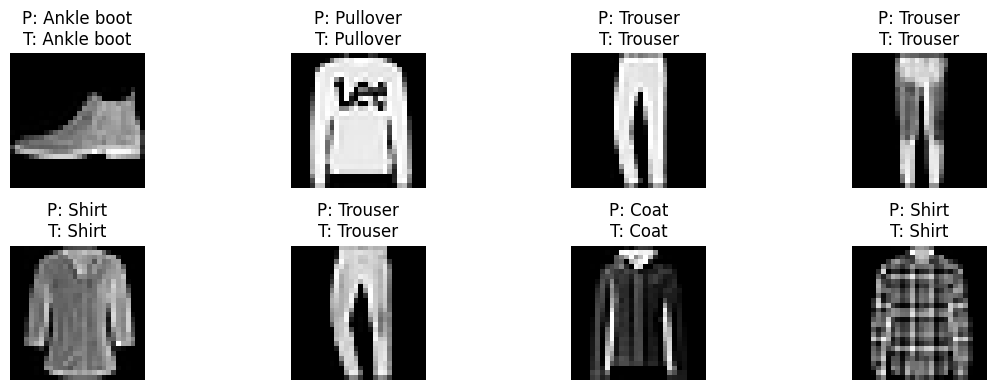

In [12]:
# Show first 8 images with predictions
plt.figure(figsize=(12, 4))

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(f"P: {class_names[preds[i]]}\nT: {class_names[labels[i]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [17]:
# ============================================
# Save image from dataset to local
# ============================================
from torchvision.utils import save_image

# take an image from test dataset
img, label = test_ds[10]

# save it to file
save_image(img, "test_sample.png")

# print label for reference
label, class_names[label]


(4, 'Coat')

In [18]:
# ============================================
# Input downloaded image to model
# ============================================
from google.colab import files
uploaded = files.upload()


Saving test_sample.png to test_sample (1).png


In [19]:
# ============================================
# Predict downloaded image
# ============================================
img_path = list(uploaded.keys())[0]
predict_image(img_path)


'Coat'

In [20]:
# ============================================
# Download tarined model
# ============================================
from google.colab import files
files.download("models/fashion_cnn_best.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>